### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
from y0.algorithm import falsification
import y0.examples
from y0.dsl import Variable
import copy
import networkx as nx
import pandas as pd

import seaborn as sns
from itertools import chain
from tqdm import tqdm

%matplotlib inline

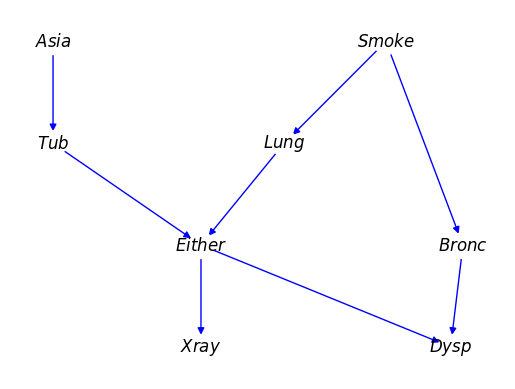

In [2]:
asia_G = y0.examples.asia_example.graph
asia_df = y0.examples.asia_example.data

asia_G.draw()

In [3]:
asia_df

,Unnamed: 0,Asia,Smoke,Tub,Lung,Bronc,Either,Xray,Dysp
0,1,-1,1,-1,-1,1,-1,-1,1
1,2,-1,1,-1,-1,-1,-1,-1,-1
2,3,-1,-1,1,-1,-1,1,1,1
3,4,-1,-1,-1,-1,1,-1,-1,1
4,5,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...
4995,4996,-1,-1,-1,-1,1,-1,1,1
4996,4997,-1,-1,-1,-1,-1,-1,-1,-1
4997,4998,-1,-1,-1,-1,-1,-1,-1,-1
4998,4999,-1,1,-1,-1,-1,-1,-1,1


In [4]:
issues = falsification.get_graph_falsifications(asia_G, asia_df, max_given=2, verbose=True)

Checking d-separations:   0%|          | 0/28 [00:00<?, ?pair/s]

Checking conditionals:   0%|          | 0/17 [00:00<?, ?it/s]

In [5]:
issues.evidence

,left,right,given,chi^2,p,dof,Holm–Bonferroni level,flagged
6,Lung,Xray,Either,0.000000,1,1.000000,0.004167,False
4,Tub,Xray,Either,0.000000,1,1.000000,0.003571,False
2,Smoke,Tub,,0.000000,1,1.000000,0.003125,False
1,Either,Smoke,Lung,0.000000,1,1.000000,0.002941,False
11,Smoke,Xray,Lung,0.278697,2,0.869925,0.007143,False
10,Dysp,Xray,Either,0.617808,2,0.734251,0.006250,False
8,Lung,Tub,,0.129525,1,0.718925,0.005000,False
13,Bronc,Xray,Lung,0.697125,2,0.705702,0.010000,False
9,Asia,Lung,,0.201322,1,0.653656,0.005556,False
5,Asia,Either,Tub,0.300140,1,0.583795,0.003846,False


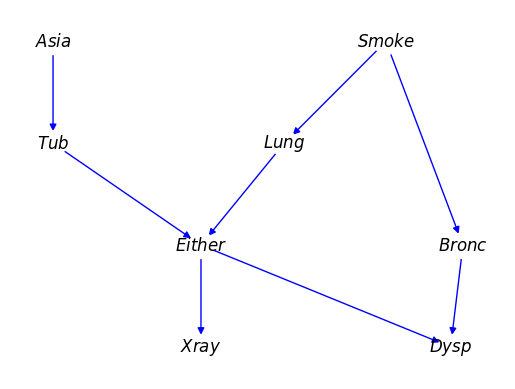

In [6]:
# Should be issues (Lung, Either) AT LEAST.
# .  Seeing issues (Lung, Xray) as well.  Is that all?
# TODO: Check d-separations by hand...
asia_G2 = copy.deepcopy(asia_G)
asia_G2.draw()

In [7]:
asia_G2.directed.remove_edge(
    Variable("Lung"), Variable("Either")
)  # delete_diedge("Lung", "Either")
issues = falsification.get_graph_falsifications(asia_G2, asia_df)

In [8]:
issues.failures

Series([], dtype: float64)

In [9]:
issues.evidence

,left,right,given,chi^2,p,dof,Holm–Bonferroni level,flagged
13,Tub,Xray,Either,0.000000,1,1.000000e+00,0.005556,False
3,Dysp,Tub,Either,0.000000,1,1.000000e+00,0.002632,False
1,Smoke,Tub,,0.000000,1,1.000000e+00,0.002381,False
4,Dysp,Xray,Either,0.617808,2,7.342514e-01,0.002778,False
9,Lung,Tub,,0.129525,1,7.189249e-01,0.003846,False
10,Asia,Lung,,0.201322,1,6.536561e-01,0.004167,False
16,Asia,Either,Tub,0.300140,1,5.837949e-01,0.008333,False
17,Asia,Xray,Tub,0.413105,1,5.203979e-01,0.010000,False
6,Asia,Dysp,Tub,1.471978,2,4.790315e-01,0.003125,False
12,Bronc,Lung,Smoke,3.477138,2,1.757718e-01,0.005000,False
